**Importing Packages** <br>
First, we import essential Python packages to help us process and analyze the data, including pyspark for big data handling, pandas for data manipulation, plotly for interactive visualizations, and datetime for working with dates and times.

In [ ]:
!pip install pyspark
!pip install plotly
!pip install pandas
!pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 916.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 6.7 MB/s eta 0:00:00


**Mounting Google Drive in Google Colab** <br>
We import the **drive** module from **google.colab** to connect Google Colab with Google Drive. Then, we use drive.mount('/content/drive') to mount Google Drive at the specified path, allowing us to access files and datasets stored in Drive directly from the Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This PySpark code performs a **comprehensive analysis of YouTube trending videos** to extract actionable insights for content creators. Here's a concise breakdown:

### **Key Components:**
1. **Data Loading & Cleaning**  
   - Imports YouTube data from CSV (Brazil region)  
   - Handles null values, converts timestamps, calculates metrics like `days_to_trend`, `engagement_score`, and maps category IDs to names.

2. **Four Core Analyses**  
   - **Best Posting Times**: Identifies optimal days/hours for max views/engagement.  
   - **Content Insights**: Analyzes top-performing categories, ideal title lengths, and tag usage.  
   - **Regional Trends**: Compares performance across channels/countries.  
   - **Engagement Patterns**: Examines like/comment ratios and tag impact.

3. **Visualizations & Outputs**  
   - Generates bar charts for key metrics (views by day/hour/category).  
   - Saves results to CSV files (`day_analysis.csv`, `category_analysis.csv`, etc.).  
   - Produces a **data-driven recommendation report** with actionable tips (optimal posting times, tags, title lengths).

### **Technical Stack**  
- **PySpark**: For scalable data processing.  
- **Pandas/Matplotlib**: For aggregations and visualizations.  
- **Google Colab Integration**: Mounts Drive for data access.  

### **Outcome**:  
Helps creators optimize upload schedules, content strategy, and engagement tactics based on trending video patterns.  


===== YouTube Trending Videos Analysis =====

1. BEST TIMES TO POST

Best Days to Post:
   day_name     avg_views  avg_engagement  avg_days_to_trend
0    Friday  2.366912e+06        5.130577           5.042556
1  Saturday  2.146326e+06        0.033755           4.792531
2    Monday  1.507837e+06        0.037052           4.658785

Best Hours to Post:
   publish_hour     avg_views  avg_engagement  avg_days_to_trend
0           9.0  9.195995e+06        0.034920           4.656340
1           4.0  5.917534e+06        0.033287           4.375722
2           7.0  5.014146e+06        0.023879           4.390385

Time to Trend:
   avg_days_to_trend  median_days_to_trend  min_days_to_trend  \
0           4.793497                   5.0                  0   

   max_days_to_trend  
0                 34  

2. CONTENT INSIGHTS

Top Performing Categories:
     video_category_name     avg_views  avg_engagement  video_count
0                  Music  3.235165e+06        4.640044        58413
1   Scien

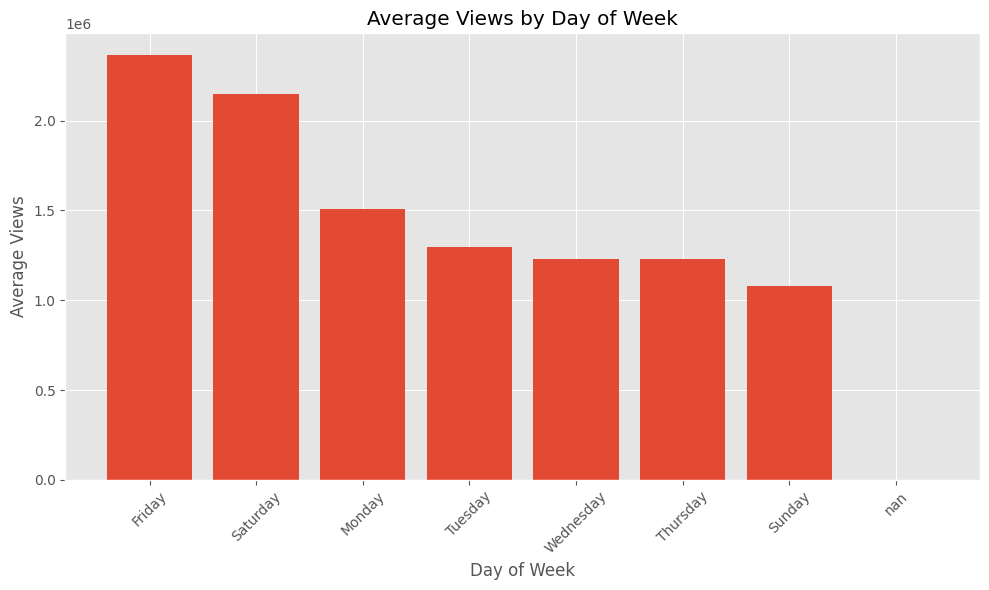

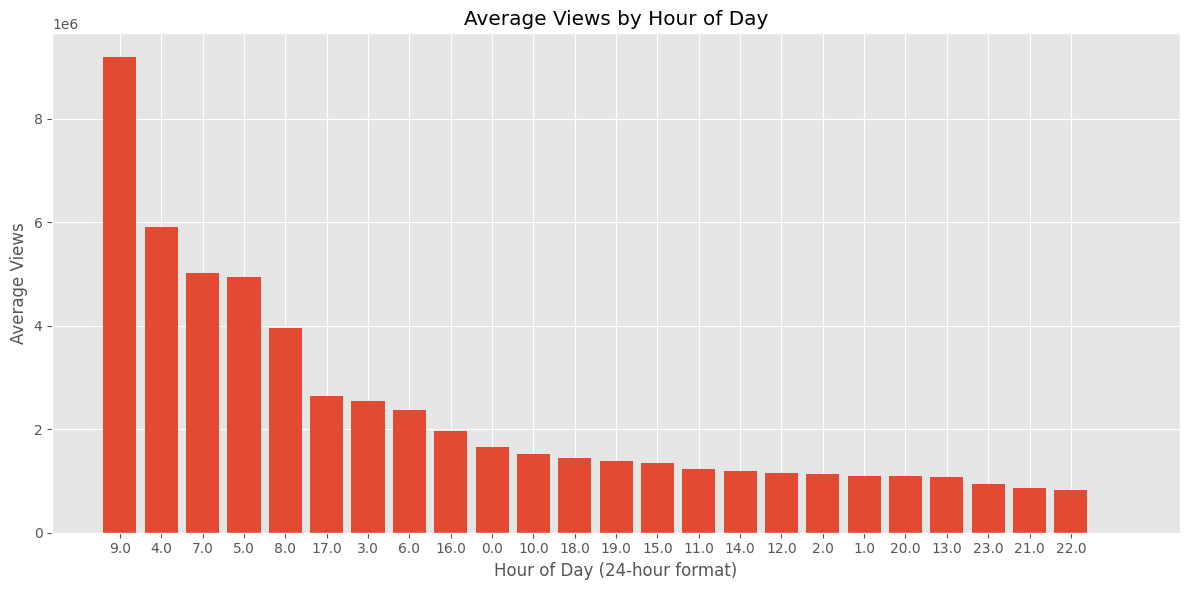

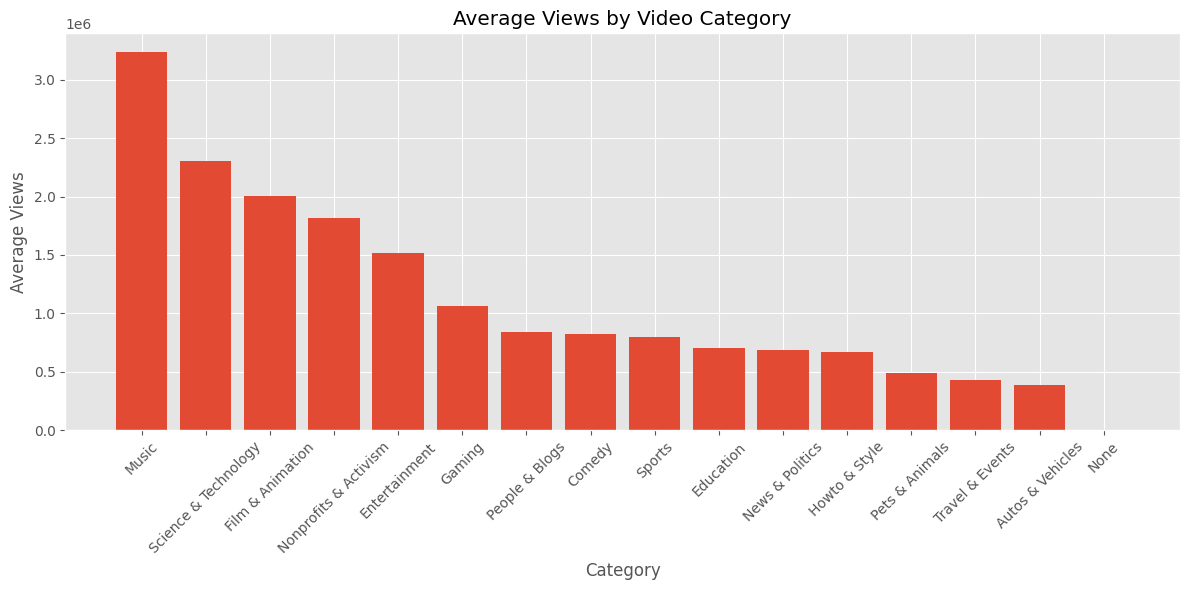

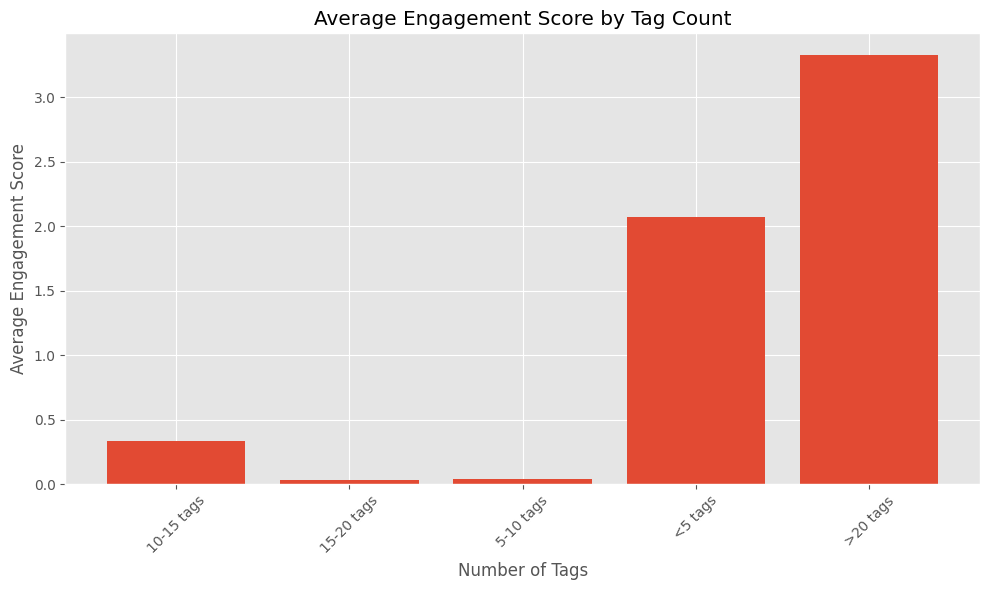

Visualizations displayed successfully!

    RECOMMENDATIONS FOR YOUTUBE CONTENT CREATORS

    Based on our analysis of trending YouTube videos, here are data-backed recommendations:

    1. WHEN TO POST:
       - Best day: Friday
       - Best hours: 9.0:00, 4.0:00, 7.0:00
       - Videos typically take 4 days to trend after posting

    2. CONTENT STRATEGY:
       - Most successful categories: Music, Science & Technology, Film & Animation
       - Aim for 10 tags per video
       - Ideal title length: 52 characters

    3. REGIONAL CONSIDERATIONS:
       - Top performing channels: Mv Ryhan, MrBeast, Thanh Thảo Official
       - Check country_category_analysis.csv for category preferences by channel
       - Check country_hour_analysis.csv for best posting times by channel

    4. ENGAGEMENT TIPS:
       - Categories with highest engagement: Howto & Style, Comedy, Pets & Animals
       - Including >20 tags yields highest engagement

    For detailed insights, please refer to the genera

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, date_format, to_timestamp, datediff, hour, dayofweek,
    regexp_replace, expr, concat_ws, when, avg, count, desc,
    lit, round, sum, udf, length, split, size
)
from pyspark.sql.types import DoubleType, IntegerType, TimestampType
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("YouTube Trending Videos Analysis") \
    .getOrCreate()

# Load the dataset
# Adjust the path to your dataset file
youtube_df = spark.read.csv("/content/drive/MyDrive/US_youtube_trending_data.csv", header=True, inferSchema=True)

# Step 1: Data Cleaning
def clean_data(df):
    # Convert timestamp strings to proper timestamp format
    df = df.withColumn("video_published_timestamp",
                      to_timestamp(col("publishedAt"), "yyyy-MM-dd'T'HH:mm:ss'Z'"))

    df = df.withColumn("trending_date", to_timestamp(col("trending_date"), "yyyy-MM-dd'T'HH:mm:ss'Z'"))

    # Handle null values
    numerical_cols = ["view_count", "likes", "dislikes", "comment_count"]

    for column in numerical_cols:
        df = df.withColumn(column, col(column).cast(IntegerType()))
        # Replacing nulls with 0 for numerical columns
        df = df.withColumn(column, when(col(column).isNull(), 0).otherwise(col(column)))

    # Calculate days to trend (from publish to trending)
    df = df.withColumn("days_to_trend",
                      datediff(col("trending_date"), col("video_published_timestamp")))

    # Calculate hour of day and day of week for publishing
    df = df.withColumn("publish_hour", hour(col("video_published_timestamp")))
    df = df.withColumn("publish_day", dayofweek(col("video_published_timestamp")))

    # Parse video tags
    df = df.withColumn("tag_count",
                      when(col("tags").isNull() | (col("tags") == ""), 0)
                      .otherwise(size(split(col("tags"), "\\|"))))

    # Create engagement score (normalized weighted sum of likes, dislikes, and comments)
    df = df.withColumn("engagement_score",
                      (col("likes") * 0.4 +
                       col("comment_count") * 0.6) /
                      when(col("view_count") > 0, col("view_count")).otherwise(1))

    # Map category IDs to names
    category_mapping = {
        1: "Film & Animation",
        2: "Autos & Vehicles",
        10: "Music",
        15: "Pets & Animals",
        17: "Sports",
        18: "Short Movies",
        19: "Travel & Events",
        20: "Gaming",
        21: "Videoblogging",
        22: "People & Blogs",
        23: "Comedy",
        24: "Entertainment",
        25: "News & Politics",
        26: "Howto & Style",
        27: "Education",
        28: "Science & Technology",
        29: "Nonprofits & Activism",
        30: "Movies",
        31: "Anime/Animation",
        32: "Action/Adventure",
        33: "Classics",
        34: "Comedy",
        35: "Documentary",
        36: "Drama",
        37: "Family",
        38: "Foreign",
        39: "Horror",
        40: "Sci-Fi/Fantasy",
        41: "Thriller",
        42: "Shorts",
        43: "Shows",
        44: "Trailers"
    }

    from pyspark.sql.functions import create_map

    # Flatten the dictionary items into a list
    map_items = []
    for k, v in category_mapping.items():
        map_items.append(lit(k))
        map_items.append(lit(v))

    mapping_expr = create_map(*map_items)
    df = df.withColumn("video_category_name", mapping_expr[col("categoryId")])

    return df

# Clean the dataset
clean_youtube_df = clean_data(youtube_df)

# Step 2: Basic Analysis

# 1. Best Times to Post Analysis
def analyze_best_posting_times(df):
    # Best days of the week
    day_analysis = df.groupBy("publish_day") \
        .agg(
            count("*").alias("video_count"),
            avg("view_count").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement"),
            avg("days_to_trend").alias("avg_days_to_trend")
        ) \
        .orderBy(desc("avg_views"))

    # Best hours of the day
    hour_analysis = df.groupBy("publish_hour") \
        .agg(
            count("*").alias("video_count"),
            avg("view_count").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement"),
            avg("days_to_trend").alias("avg_days_to_trend")
        ) \
        .orderBy(desc("avg_views"))

    # Time to trend analysis
    trend_time_analysis = df.groupBy() \
        .agg(
            avg("days_to_trend").alias("avg_days_to_trend"),
            expr("percentile(days_to_trend, 0.5)").alias("median_days_to_trend"),
            expr("min(days_to_trend)").alias("min_days_to_trend"),
            expr("max(days_to_trend)").alias("max_days_to_trend")
        )

    return {
        "day_analysis": day_analysis,
        "hour_analysis": hour_analysis,
        "trend_time_analysis": trend_time_analysis
    }

# 2. Content Insights Analysis
def analyze_content_insights(df):
    # Best performing categories
    category_analysis = df.groupBy("video_category_name") \
        .agg(
            count("*").alias("video_count"),
            avg("view_count").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement"),
            avg("days_to_trend").alias("avg_days_to_trend")
        ) \
        .orderBy(desc("avg_views"))

    # Tag usage analysis
    tag_analysis = df.groupBy() \
        .agg(
            avg("tag_count").alias("avg_tag_count"),
            expr("percentile(tag_count, 0.5)").alias("median_tag_count"),
            expr("percentile(tag_count, 0.25)").alias("percentile_25_tag_count"),
            expr("percentile(tag_count, 0.75)").alias("percentile_75_tag_count")
        )

    # Title length analysis
    df = df.withColumn("title_length", length(col("title")))

    title_analysis = df.groupBy() \
        .agg(
            avg("title_length").alias("avg_title_length"),
            expr("percentile(title_length, 0.5)").alias("median_title_length"),
            expr("percentile(title_length, 0.25)").alias("percentile_25_title_length"),
            expr("percentile(title_length, 0.75)").alias("percentile_75_title_length")
        )

    return {
        "category_analysis": category_analysis,
        "tag_analysis": tag_analysis,
        "title_analysis": title_analysis
    }

# 3. Regional Analysis
def analyze_regional_differences(df):
    # Compare trends across different countries
    country_category_analysis = df.groupBy("channelTitle", "video_category_name") \
        .agg(
            count("*").alias("video_count"),
            avg("view_count").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement")
        ) \
        .orderBy("channelTitle", desc("avg_views"))

    # Best posting times per country
    country_hour_analysis = df.groupBy("channelTitle", "publish_hour") \
        .agg(
            count("*").alias("video_count"),
            avg("view_count").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement")
        ) \
        .orderBy("channelTitle", desc("avg_views"))

    country_day_analysis = df.groupBy("channelTitle", "publish_day") \
        .agg(
            count("*").alias("video_count"),
            avg("view_count").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement")
        ) \
        .orderBy("channelTitle", desc("avg_views"))

    # Overall country performance
    country_analysis = df.groupBy("channelTitle") \
        .agg(
            count("*").alias("video_count"),
            avg("view_count").alias("avg_views"),
            avg("likes").alias("avg_likes"),
            avg("comment_count").alias("avg_comments"),
            avg("engagement_score").alias("avg_engagement"),
            avg("days_to_trend").alias("avg_days_to_trend")
        ) \
        .orderBy(desc("avg_views"))

    return {
        "country_category_analysis": country_category_analysis,
        "country_hour_analysis": country_hour_analysis,
        "country_day_analysis": country_day_analysis,
        "country_analysis": country_analysis
    }

# 4. Engagement Analysis
def analyze_engagement_patterns(df):
    # What drives comments
    comment_analysis = df.select("title", "video_category_name",
                               "tag_count", "view_count", "likes",
                               "comment_count", "engagement_score")

    # Like-to-view ratios by category
    like_view_ratio_by_category = df.withColumn(
        "like_view_ratio",
        when(col("view_count") > 0, col("likes") / col("view_count")).otherwise(0)
    ).groupBy("video_category_name") \
        .agg(
            avg("like_view_ratio").alias("avg_like_view_ratio"),
            count("*").alias("video_count")
        ) \
        .orderBy(desc("avg_like_view_ratio"))

    # Comment-to-view ratios by category
    comment_view_ratio_by_category = df.withColumn(
        "comment_view_ratio",
        when(col("view_count") > 0, col("comment_count") / col("view_count")).otherwise(0)
    ).groupBy("video_category_name") \
        .agg(
            avg("comment_view_ratio").alias("avg_comment_view_ratio"),
            count("*").alias("video_count")
        ) \
        .orderBy(desc("avg_comment_view_ratio"))

    # Engagement score by various factors
    engagement_by_tag_count = df.withColumn(
        "tag_bucket",
        when(col("tag_count") < 5, "<5 tags")
        .when(col("tag_count") < 10, "5-10 tags")
        .when(col("tag_count") < 15, "10-15 tags")
        .when(col("tag_count") < 20, "15-20 tags")
        .otherwise(">20 tags")
    ).groupBy("tag_bucket") \
        .agg(
            avg("engagement_score").alias("avg_engagement"),
            count("*").alias("video_count")
        ) \
        .orderBy("tag_bucket")

    return {
        "comment_analysis": comment_analysis,
        "like_view_ratio_by_category": like_view_ratio_by_category,
        "comment_view_ratio_by_category": comment_view_ratio_by_category,
        "engagement_by_tag_count": engagement_by_tag_count
    }

# Run all analyses
time_analysis = analyze_best_posting_times(clean_youtube_df)
content_analysis = analyze_content_insights(clean_youtube_df)
regional_analysis = analyze_regional_differences(clean_youtube_df)
engagement_analysis = analyze_engagement_patterns(clean_youtube_df)

# Convert to pandas for visualization and display top results
day_mapping = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}
day_analysis_pd = time_analysis["day_analysis"].toPandas()
day_analysis_pd["day_name"] = day_analysis_pd["publish_day"].map(day_mapping)
day_analysis_pd = day_analysis_pd.sort_values("avg_views", ascending=False)

hour_analysis_pd = time_analysis["hour_analysis"].toPandas()
hour_analysis_pd = hour_analysis_pd.sort_values("avg_views", ascending=False)

category_analysis_pd = content_analysis["category_analysis"].toPandas()
category_analysis_pd = category_analysis_pd.sort_values("avg_views", ascending=False)

country_analysis_pd = regional_analysis["country_analysis"].toPandas()
country_analysis_pd = country_analysis_pd.sort_values("avg_views", ascending=False)

like_view_ratio_pd = engagement_analysis["like_view_ratio_by_category"].toPandas()
comment_view_ratio_pd = engagement_analysis["comment_view_ratio_by_category"].toPandas()

# Print insights summary
print("===== YouTube Trending Videos Analysis =====")
print("\n1. BEST TIMES TO POST")
print("\nBest Days to Post:")
print(day_analysis_pd[["day_name", "avg_views", "avg_engagement", "avg_days_to_trend"]].head(3))
print("\nBest Hours to Post:")
print(hour_analysis_pd[["publish_hour", "avg_views", "avg_engagement", "avg_days_to_trend"]].head(3))
print("\nTime to Trend:")
print(time_analysis["trend_time_analysis"].toPandas())

print("\n2. CONTENT INSIGHTS")
print("\nTop Performing Categories:")
print(category_analysis_pd[["video_category_name", "avg_views", "avg_engagement", "video_count"]].head(5))
print("\nTitle Length Analysis:")
print(content_analysis["title_analysis"].toPandas())
print("\nTag Usage Analysis:")
print(content_analysis["tag_analysis"].toPandas())

print("\n3. REGIONAL DIFFERENCES")
print("\nPerformance by Channel:")
print(country_analysis_pd[["channelTitle", "avg_views", "avg_engagement", "video_count"]].head(5))
print("\nFor detailed channel-specific insights, see country_category_analysis, country_hour_analysis, and country_day_analysis dataframes")

print("\n4. ENGAGEMENT PATTERNS")
print("\nCategories with Highest Like-to-View Ratio:")
print(like_view_ratio_pd[["video_category_name", "avg_like_view_ratio", "video_count"]].head(5))
print("\nCategories with Highest Comment-to-View Ratio:")
print(comment_view_ratio_pd[["video_category_name", "avg_comment_view_ratio", "video_count"]].head(5))
print("\nEngagement by Tag Count:")
print(engagement_analysis["engagement_by_tag_count"].toPandas())

# Generate visualizations for key metrics
def create_visualizations():
    plt.style.use('ggplot')

    # 1. Best day to post
    plt.figure(figsize=(10, 6))

    # Ensure day_name is a string and avg_views is a float
    day_analysis_pd["day_name"] = day_analysis_pd["day_name"].astype(str)  # Convert to string
    day_analysis_pd["avg_views"] = day_analysis_pd["avg_views"].astype(float)  # Convert to float

    # Drop rows with NaN values in day_name or avg_views
    day_analysis_pd_cleaned = day_analysis_pd.dropna(subset=["day_name", "avg_views"])

    # Plot the bar chart
    plt.bar(day_analysis_pd_cleaned["day_name"], day_analysis_pd_cleaned["avg_views"])
    plt.title("Average Views by Day of Week")
    plt.xlabel("Day of Week")
    plt.ylabel("Average Views")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Best hour to post
    plt.figure(figsize=(12, 6))

    # Ensure publish_hour is a string and avg_views is a float
    hour_analysis_pd["publish_hour"] = hour_analysis_pd["publish_hour"].astype(str)  # Convert to string
    hour_analysis_pd["avg_views"] = hour_analysis_pd["avg_views"].astype(float)  # Convert to float

    # Drop rows with NaN values in publish_hour or avg_views
    hour_analysis_pd_cleaned = hour_analysis_pd.dropna(subset=["publish_hour", "avg_views"])

    # Plot the bar chart
    plt.bar(hour_analysis_pd_cleaned["publish_hour"], hour_analysis_pd_cleaned["avg_views"])
    plt.title("Average Views by Hour of Day")
    plt.xlabel("Hour of Day (24-hour format)")
    plt.ylabel("Average Views")
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

    # 3. Top categories
    plt.figure(figsize=(12, 6))

    # Ensure video_category_name is a string and avg_views is a float
    category_analysis_pd["video_category_name"] = category_analysis_pd["video_category_name"].astype(str)  # Convert to string
    category_analysis_pd["avg_views"] = category_analysis_pd["avg_views"].astype(float)  # Convert to float

    # Drop rows with NaN values in video_category_name or avg_views
    category_analysis_pd_cleaned = category_analysis_pd.dropna(subset=["video_category_name", "avg_views"])

    # Plot the bar chart
    plt.bar(category_analysis_pd_cleaned["video_category_name"], category_analysis_pd_cleaned["avg_views"])
    plt.title("Average Views by Video Category")
    plt.xlabel("Category")
    plt.ylabel("Average Views")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



    # 5. Engagement by tag count
    plt.figure(figsize=(10, 6))

    # Ensure tag_bucket is a string and avg_engagement is a float
    engagement_by_tag = engagement_analysis["engagement_by_tag_count"].toPandas()
    engagement_by_tag["tag_bucket"] = engagement_by_tag["tag_bucket"].astype(str)  # Convert to string
    engagement_by_tag["avg_engagement"] = engagement_by_tag["avg_engagement"].astype(float)  # Convert to float

    # Drop rows with NaN values in tag_bucket or avg_engagement
    engagement_by_tag_cleaned = engagement_by_tag.dropna(subset=["tag_bucket", "avg_engagement"])

    # Plot the bar chart
    plt.bar(engagement_by_tag_cleaned["tag_bucket"], engagement_by_tag_cleaned["avg_engagement"])
    plt.title("Average Engagement Score by Tag Count")
    plt.xlabel("Number of Tags")
    plt.ylabel("Average Engagement Score")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("Visualizations displayed successfully!")

# Uncomment to generate visualizations
create_visualizations()

# Save results to CSV files for further analysis
time_analysis["day_analysis"].toPandas().to_csv("day_analysis.csv", index=False)
time_analysis["hour_analysis"].toPandas().to_csv("hour_analysis.csv", index=False)
content_analysis["category_analysis"].toPandas().to_csv("category_analysis.csv", index=False)
regional_analysis["country_analysis"].toPandas().to_csv("country_analysis.csv", index=False)
regional_analysis["country_category_analysis"].toPandas().to_csv("country_category_analysis.csv", index=False)

# Generate final report with recommendations
def generate_recommendations():
    # Get top day
    top_day = day_analysis_pd.iloc[0]["day_name"] if not day_analysis_pd.empty else "N/A"

    # Get top hours (top 3)
    top_hours = hour_analysis_pd.iloc[0:3]["publish_hour"].tolist() if not hour_analysis_pd.empty else ["N/A"]

    # Get top categories (top 3)
    top_categories = category_analysis_pd.iloc[0:3]["video_category_name"].tolist() if not category_analysis_pd.empty else ["N/A"]

    # Get optimal tag count
    tag_analysis = content_analysis["tag_analysis"].toPandas()
    optimal_tag_count = int(tag_analysis.iloc[0]["median_tag_count"]) if not tag_analysis.empty else "N/A"

    # Get optimal title length
    title_analysis = content_analysis["title_analysis"].toPandas()
    optimal_title_length = int(title_analysis.iloc[0]["median_title_length"]) if not title_analysis.empty else "N/A"

    # Check if trend_time_analysis exists and is not empty
    if "trend_time_analysis" in time_analysis and not time_analysis["trend_time_analysis"].isEmpty():
        avg_days_to_trend = int(time_analysis["trend_time_analysis"].toPandas().iloc[0]["avg_days_to_trend"])
    else:
        avg_days_to_trend = "N/A"

    # Get engagement data safely
    if not like_view_ratio_pd.empty:
        top_engagement_categories = ', '.join(like_view_ratio_pd.head(3)["video_category_name"].tolist())
    else:
        top_engagement_categories = "N/A"

    # Get tag engagement data safely
    engagement_by_tag_df = engagement_analysis["engagement_by_tag_count"].toPandas()
    if not engagement_by_tag_df.empty:
        best_tag_bucket = engagement_by_tag_df.iloc[engagement_by_tag_df["avg_engagement"].idxmax()]["tag_bucket"]
    else:
        best_tag_bucket = "N/A"

    recommendations = f"""
    RECOMMENDATIONS FOR YOUTUBE CONTENT CREATORS

    Based on our analysis of trending YouTube videos, here are data-backed recommendations:

    1. WHEN TO POST:
       - Best day: {top_day}
       - Best hours: {', '.join([str(hour) + ':00' for hour in top_hours]) if top_hours[0] != "N/A" else "N/A"}
       - Videos typically take {avg_days_to_trend} days to trend after posting

    2. CONTENT STRATEGY:
       - Most successful categories: {', '.join(top_categories)}
       - Aim for {optimal_tag_count} tags per video
       - Ideal title length: {optimal_title_length} characters

    3. REGIONAL CONSIDERATIONS:
       - Top performing channels: {', '.join(country_analysis_pd.head(3)["channelTitle"].tolist()) if not country_analysis_pd.empty else "N/A"}
       - Check country_category_analysis.csv for category preferences by channel
       - Check country_hour_analysis.csv for best posting times by channel

    4. ENGAGEMENT TIPS:
       - Categories with highest engagement: {top_engagement_categories}
       - Including {best_tag_bucket} yields highest engagement

    For detailed insights, please refer to the generated CSV files and visualizations.
    """

    print(recommendations)

    # Save recommendations to a file
    with open("youtube_recommendations.txt", "w") as f:
        f.write(recommendations)

# Uncomment to generate recommendations
generate_recommendations()

# Return the spark context for any additional processing
spark